# Explorative Country Analysis

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



from os import path
from PIL import Image
import os
import random

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text 

# Import tokenizers and regex

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re     # Python package for regular expressions
color = sns.color_palette()
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px
from wordcloud import WordCloud, ImageColorGenerator
from scipy.ndimage import gaussian_gradient_magnitude
plt.style.use('dark_background')

In [3]:
# read in the data
url = "https://raw.githubusercontent.com/samnangpeou/CAPSTONE_GA/main/data/country_lyrics.csv"
df = pd.read_csv(url)

In [4]:
# prior checks
df.dtypes

lyrics    object
url       object
artist    object
dtype: object

In [5]:
df.shape

(5735, 3)

In [6]:
df.dropna(inplace=True)

In [7]:
df.drop([i for i in df[df['lyrics'].str.len() < 400].index],
        inplace=True)

#### Listing all artists in the corpus.

In [8]:
df['artist'].value_counts()

Kenny Chesney    200
Taylor Swift     200
Reba McEntire    199
George Strait    199
Alan Jackson     193
                ... 
Jordan Davis      20
Jimmie Allen      18
Filmore           15
Tyler Rich        11
Morgan Evans      11
Name: artist, Length: 74, dtype: int64

In [9]:
df['artist'].nunique()

74

In [10]:
df['lyrics_length'] = df['lyrics'].str.len()

In [11]:
# Average number of characters per document.
df['lyrics_length'].mean()

1286.0449260042283

In [12]:
df['lyrics_word_count'] = df['lyrics'].str.split().apply(len)

In [13]:
# Average number of words per document.
df['lyrics_word_count'].mean()

259.41895701198024

#### Distribution of songs per Artists

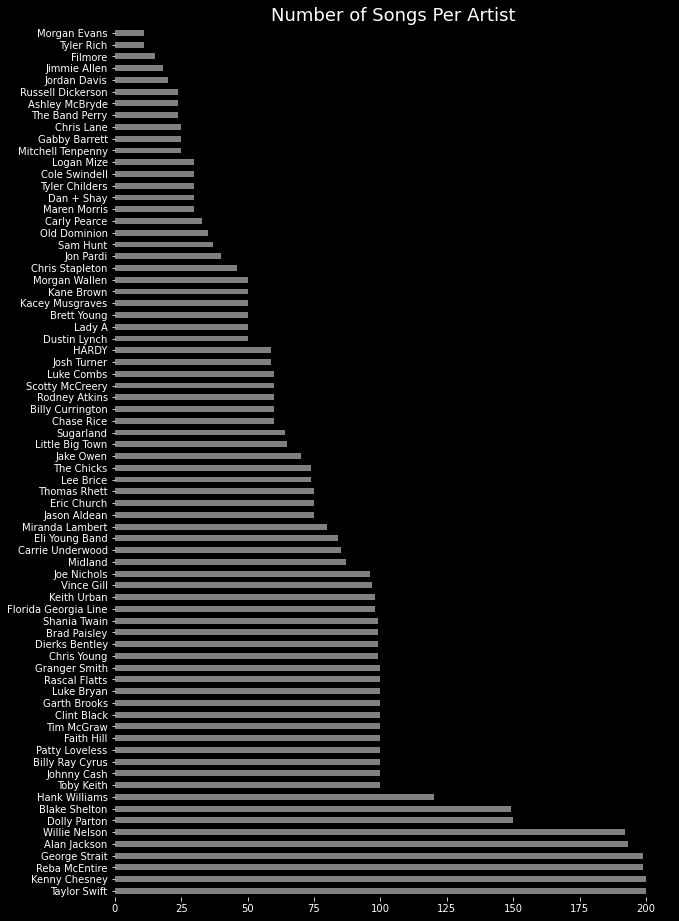

In [13]:
# plot song counts per artist
plt.figure(figsize=(10,16))
ax1 = df['artist'].value_counts(ascending=False).plot(kind='barh', color='grey')
ax1.set_title("Number of Songs Per Artist", fontsize=18);
ax1.set_frame_on(False)

In [14]:
# dropping shorter songs.
df.drop([i for i in df['lyrics_word_count'].sort_values(ascending=True)[:50].index],
        inplace=True)

#### Dropping all songs pertaining to Christmas because a lot of the songs are the same songs sung by different artists. And we don't want our model thinking that Christmas should be mentioned outside of the winter time.

In [15]:
df.drop([i for i in df[df['url'].str.contains('christmas')].index],
       inplace=True)

In [16]:
df.drop([i for i in df[df['url'].str.contains('winter')].index],
       inplace=True)

In [17]:
df.drop([i for i in df[df['url'].str.contains('snow')].index], inplace=True)

In [18]:
df.drop([i for i in df[df['url'].str.contains('noel')].index],inplace=True)

#### Lemmatizing to rid of plurality

In [19]:
# initialize lemmatizer
lem = WordNetLemmatizer()

# lemmatize
df['lyrics'] = df['lyrics'].map(lambda x: lem.lemmatize(x))

In [20]:
# adding stop words for the TFIDF

my_words = ["I'm", "don't", "I've", "want", "won't", "I'd", "I'll", "we're", "know", "maybe", "did", "Yeah", "you're", "can't", "come",
           "did", "got", "think", "got", "just", "like", "Cause", 'cause', 'don', 'll', 've', 'won', 'yeah']

In [21]:
# unioning the custom stop words with the base stopwords

stop_words = text.ENGLISH_STOP_WORDS.union(my_words)

In [22]:
# initialize TFIDF

tvec = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1))

In [23]:
# fit TFIDF

X = tvec.fit_transform(df['lyrics'])

#### These are the most used words in the corpus.

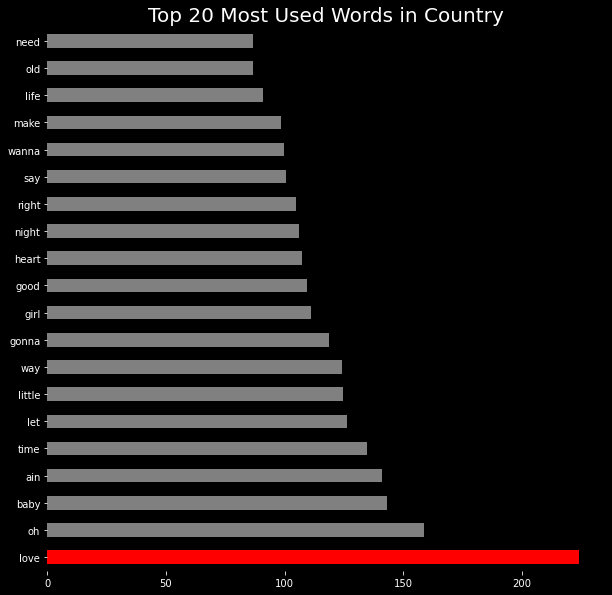

In [25]:
# plotting 20 most used words

X_df = pd.DataFrame(X.todense(),
                         columns = tvec.get_feature_names())

colors20 = ['red']
for i in range(19):
    colors20.append('grey',)

plt.figure(figsize=(10,10))
ax2 = X_df.sum().sort_values(ascending=False).head(20).plot(kind='barh', color = colors20);
ax2.set_title('Top 20 Most Used Words in Country', fontsize=20)
ax2.set_frame_on(False)

#### These are the least most used words, a lot of the words are names of places.

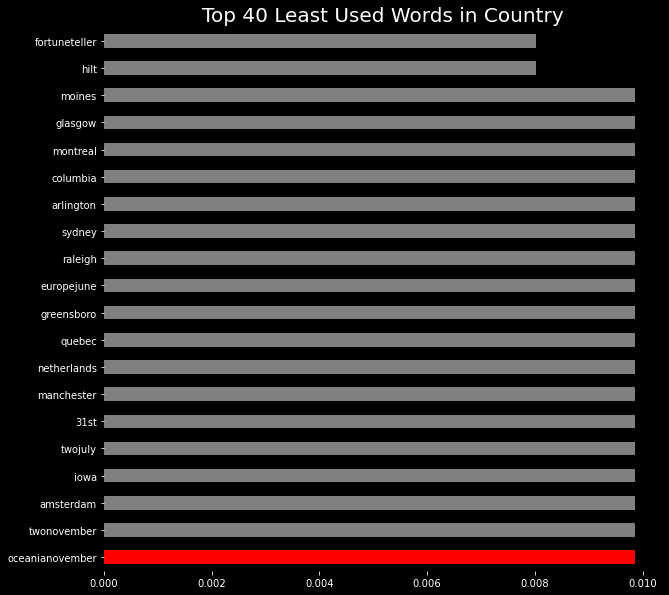

In [26]:
# plotting least used words
plt.figure(figsize=(10,10))
ax3 = X_df.sum().sort_values(ascending=False).tail(20).plot(kind='barh', color = colors20);
ax3.set_title('Top 40 Least Used Words in Country', fontsize=20)
ax3.set_frame_on(False)

#### TFIDF adds a score of importance to the words, these are actual the actual counts of words used.

In [27]:
def find_words(word):
    count = 0
    for i in df['lyrics']:
        count += i.lower().count(word)
    return count

In [28]:
# times past tense love and love was used.
find_words('loved') + find_words('love')

10278

In [29]:
# times ain't was used
find_words('ain\'t')

5010

In [30]:
# times beer was used
find_words('beer')

911

#### Using a guitar vector, and WordCloud(), you can join both images together.

##### This is a word cloud in the shape of a guitar.

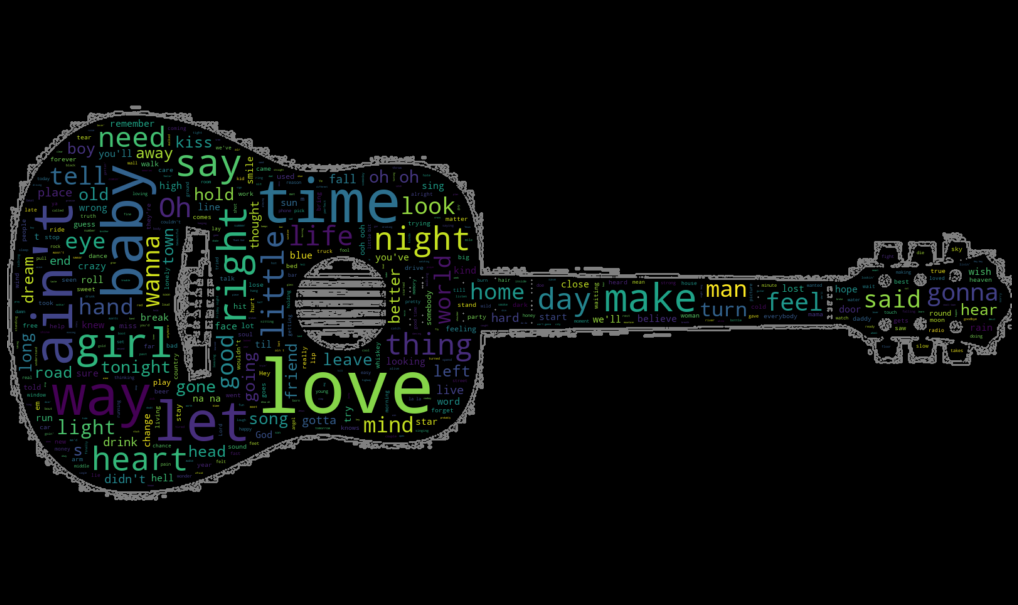

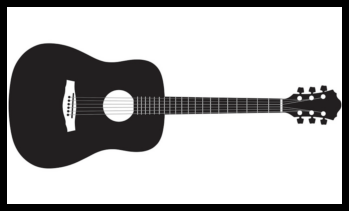

In [31]:
# creating a guitar shaped word cloud.

plt.figure(figsize=(18,18))
# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

# Read the whole text.
textt = " ".join(lyrics for lyrics in df.lyrics)

# read the mask image
# taken from
# http://www.stencilry.org/stencils/movies/alice%20in%20wonderland/255fk.jpg
guitar_mask = np.array(Image.open(path.join(d, "../img/guitar_vector.png")))

wc = WordCloud(background_color="black", max_words=2000, mask=guitar_mask,
               stopwords=stop_words, contour_width=3, contour_color='grey',margin=10).generate(textt)

# show
plt.imshow(wc,
           interpolation="bilinear")
# store to file
wc.to_file(path.join(d, "../img/guitar.png"))
plt.axis("off")
plt.figure()
plt.imshow(guitar_mask, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Sentiment Analysis!

In [32]:
# initialize SIA
sent = SentimentIntensityAnalyzer()

# map it across lyrics and create a new column to hold values
df['sentiment_scores'] = df['lyrics'].map(lambda x: sent.polarity_scores(x))

In [33]:
# unpacking dict created and appending it to the df

df = pd.concat([df.drop(['sentiment_scores'], axis=1), df['sentiment_scores'].apply(pd.Series)], axis=1)

In [35]:
{i: df[i].mean() for i in df.columns[5:]}

{'neg': 0.07442929201945593,
 'neu': 0.7812304089353266,
 'pos': 0.14433147180688177,
 'compound': 0.5102560439560424}

In [36]:
# initialize a df with just negative compounds

negative_compound = df[df['compound'] < 0]
negative_compound.head()

,lyrics,url,artist,lyrics_length,lyrics_word_count,neg,neu,pos,compound
4,"Oh, maybe I came on too strong\nMaybe I waited...",https://genius.com/Luke-combs-dive-lyrics,Luke Combs,1412,301,0.084,0.861,0.055,-0.8924
5,"Are you sitting at home, all alone, trying to ...",https://genius.com/Luke-combs-one-number-away-...,Luke Combs,1898,382,0.083,0.819,0.098,-0.2714
13,"Back in the day it was a six gun, and a six-st...",https://genius.com/Luke-combs-can-i-get-an-out...,Luke Combs,1742,332,0.163,0.761,0.076,-0.9853
16,"This is my kinda town, this is my kinda place\...",https://genius.com/Luke-combs-houston-we-got-a...,Luke Combs,1346,263,0.105,0.825,0.070,-0.8545
20,Just a junked out joint off a backroad\nBlinki...,https://genius.com/Luke-combs-cold-as-you-lyrics,Luke Combs,1096,215,0.161,0.745,0.094,-0.9534


#### Top 20 worst average compound sentiment scores among artists in the corpus.

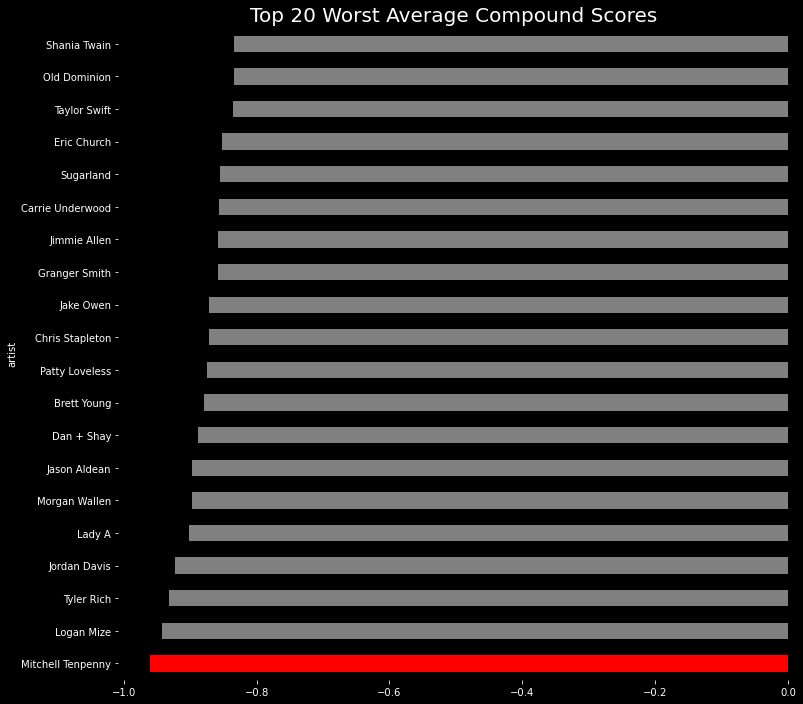

In [38]:
# plot the 20 worst compound sentiment scores
plt.figure(figsize=(12,12))
ax = negative_compound.groupby('artist')['compound'].mean().sort_values(ascending=True)[:20].plot(kind='barh', color=colors20
                                                                                                 )
ax.set_title('Top 20 Worst Average Compound Scores', fontsize=20)
ax.set_frame_on(False)

#### Top 20 Best Average Positive Sentiments!

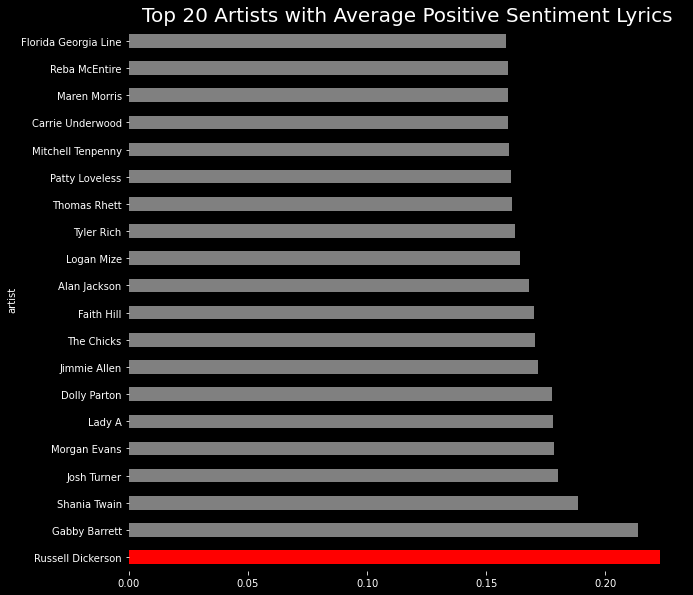

In [40]:
plt.figure(figsize=(10,10))
ax4 = df.groupby('artist')['pos'].mean().sort_values(ascending=False)[:20].plot(kind = 'barh', color=colors20)
ax4.set_title('Top 20 Artists with Average Positive Sentiment Lyrics', fontsize=20)
ax4.set_frame_on(False);

#### Distribution of compound sentiment scores among the corpus.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



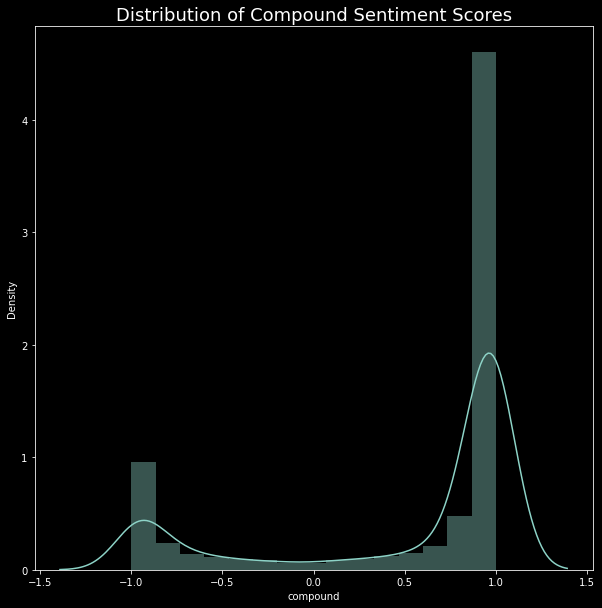

In [37]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
sns.distplot(df['compound'], bins=15, ax=ax1)
ax1.set_title('Distribution of Compound Sentiment Scores', fontsize=18)
plt.show();